In [10]:
import os
import numpy as np
import cv2
import pandas as pd
from PIL import Image
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def draw_contours_and_centroid(binary_mask, output_path):
    # Finden der Konturen
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Erstellen eines Farbbilds zum Zeichnen
    color_mask = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
    
    # Zeichnen der Konturen
    cv2.drawContours(color_mask, contours, -1, (0, 255, 0), 2)
    
    # Berechnung und Zeichnen des Schwerpunkts
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(color_mask, (cX, cY), 5, (0, 0, 255), -1)
    
    # Speichern des Bildes mit Konturen und Schwerpunkt
    cv2.imwrite(output_path, color_mask)


# Dice Metric
def dice_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

# Benutzerdefinierte Verlustfunktion
def combined_loss(y_true, y_pred, smooth=1e-6, binary_weight=0.5, dice_weight=0.5):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)
    dice_loss = 1 - (2. * intersection + smooth) / (union + smooth)
    return binary_weight * bce + dice_weight * dice_loss
# Laden und Vorverarbeiten der Bilder mit Pillow
def load_and_preprocess_image_pillow(img_path):
    img = Image.open(img_path).convert('L')  # Convert to grayscale
    img = img.resize((256, 192))  # Größe anpassen (Beispiel: 256x196)
    img = np.array(img)  # PIL Image zu numpy Array konvertieren
    img = img / 255.0  # Normalisierung auf den Bereich [0, 1]
    img = np.expand_dims(img, axis=-1)  # Für einen Kanal (Grayscale)
    return img

# Vorhersage mit dem Modell machen
def predict_with_model(model, image):
    image = np.expand_dims(image, axis=0)  # Batch-Dimension hinzufügen
    predicted_mask = model.predict(image)  # Vorhersage machen
    return np.squeeze(predicted_mask)  # Batch-Dimension entfernen

# Funktion zur Berechnung der mittleren Konturgröße
def calculate_average_contour_size(contour):
    perimeter = cv2.arcLength(contour, True)
    if perimeter == 0:
        return 0
    return cv2.contourArea(contour) / perimeter

# Funktion zur Auswahl des besten Schwellenwerts
def find_best_threshold(mask):
    best_threshold = 0
    best_score = 0

    for threshold in np.arange(0.1, 0.5, 0.01):
        binary_mask = (mask > threshold).astype(np.uint8) * 255  # Binarisieren und in 8-bit konvertieren
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            avg_size = calculate_average_contour_size(largest_contour)
            score = avg_size  # Anpassen der Bewertungsmetrik nach Bedarf

            if score > best_score:
                best_score = score
                best_threshold = threshold

    return best_threshold

# Funktion zur Berechnung des mittleren Durchmessers
def calculate_average_diameter(contour, center, num_lines=180):
    angles = np.linspace(0, 2 * np.pi, num=num_lines, endpoint=False)
    diameters = []
    for angle in angles:
        dx = np.cos(angle)
        dy = np.sin(angle)
        intersections = []
        for i in range(-1000, 1000):
            x = int(center[0] + i * dx)
            y = int(center[1] + i * dy)
            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:
                intersections.append((x, y))
        if len(intersections) >= 2:
            d = np.linalg.norm(np.array(intersections[0]) - np.array(intersections[-1]))
            diameters.append(d)
    return np.mean(diameters)


# Pfade definieren
input_dir = "C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Testset von julia"
output_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout_3 beste bisher test/'
excel_file_path = 'C:/Users/chris/Documents/Testset.xlsx'


# Lade das Modell mit den definierten custom_objects
model = load_model('C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_unet_trained3.h5', compile=False)

# Kompiliere das Modell nachträglich
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, binary_weight=0.5, dice_weight=0.5), 
              metrics=[dice_metric])
# Modell laden
#model = tf.keras.models.load_model(model_path)


# Daten aus der Excel-Tabelle laden
predicted_diameters = []
df_manual = pd.read_excel(excel_file_path, header=0)  # Daten ab der zweiten Zeile 
manual_diameters = df_manual.iloc[:, 1].tolist()  # Durchmesser sind in der zweiten Spalte

# Debug-Ausgabe: Anzahl der manuellen Durchmesser
print(f"Anzahl der manuellen Durchmesser: {len(df_manual)}")

# Skalierungsfaktoren berechnen
scale_factor_width = 1296 / 256  # Originalbreite / skalierte Breite
scale_factor_height = 966 / 196  # Originalhöhe / skalierte Höhe

# Listen für die berechneten Durchmesser und die manuell gemessenen Durchmesser
manual_diameters = []

# Iteration über alle TIFF-Dateien im Eingabeordner
tif_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]

# Debug-Ausgabe: Anzahl der TIFF-Dateien
print(f"Anzahl der TIFF-Dateien: {len(tif_files)}")

# Überprüfen, ob die Anzahl der Dateien mit der Anzahl der manuellen Messungen übereinstimmt
if len(tif_files) != len(df_manual):
    print("Die Anzahl der Bilddateien stimmt nicht mit der Anzahl der manuellen Messungen überein.")
else:
    for i, filename in enumerate(tif_files):
        img_path = os.path.join(input_dir, filename)
        
        try:
            # Bild laden und vorverarbeiten
            image = load_and_preprocess_image_pillow(img_path)
            # Vorhersage mit dem Modell machen
            predicted_mask = predict_with_model(model, image)
            if predicted_mask is None:
                print(f"Fehler bei der Vorhersage für {filename}.")
                continue

            # Besten Schwellenwert für Konturen finden
            best_threshold = find_best_threshold(predicted_mask)

            # Maske mit dem besten Schwellenwert erstellen
            binary_mask = (predicted_mask > best_threshold).astype(np.uint8) * 255  # Binarisieren und in 8-bit konvertieren
            
            # Konturen finden
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

            if not contours:
                print(f"Keine Konturen im Bild {filename} gefunden.")
                continue

            # Filtere Konturen nach Schmalheitsverhältnis
            filtered_contours = []
            for contour in contours:
                area = cv2.contourArea(contour)
                perimeter = cv2.arcLength(contour, True)
                if perimeter == 0:
                    continue
                circularity = 4 * np.pi * (area / (perimeter * perimeter))
                if circularity > 0.5:  # Anpassen des Schmalheitsverhältnisses nach Bedarf
                    filtered_contours.append(contour)

            if not filtered_contours:
                print(f"Keine geeigneten Konturen im Bild {filename} gefunden.")
                continue

            # Die größte Kontur nach dem Flächeninhalt finden
            largest_contour = max(filtered_contours, key=cv2.contourArea)

            # Berechne den Schwerpunkt der Kontur
            M = cv2.moments(largest_contour)
            if M["m00"] == 0:
                print(f"Schwerpunkt konnte im Bild {filename} nicht berechnet werden.")
                continue
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

            # Berechne den mittleren Durchmesser
            avg_diameter_pixels = calculate_average_diameter(largest_contour, center)
            avg_diameter_micrometers = avg_diameter_pixels * (0.3745 * scale_factor_width) *0.994     #mit faktor für verzerrung

            # Berechnung des Flächeninhalts
            area_pixels = cv2.contourArea(largest_contour)
            area_micrometers = area_pixels * (0.3745 * scale_factor_width * 0.3745 * scale_factor_height)

            # Ergebnisse hinzufügen
            predicted_diameters.append(avg_diameter_micrometers)
            manual_diameters.append(df_manual.iloc[i, 0])  # Manuell gemessener Durchmesser hinzufügen

            # Ausgabepfad für das segmentierte Bild definieren
            output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_segmentiert.tif")
            draw_contours_and_centroid(binary_mask, output_path)

            # Maske als TIFF-Datei speichern
            print(f"Segmentiertes Bild für {filename} wurde gespeichert.")

            # Ergebnisse ausgeben
            print(f"Bild: {filename}, Durchmesser: {avg_diameter_micrometers:.2f} µm, Flächeninhalt: {area_micrometers:.2f} µm²")

        except Exception as e:
            print(f"Fehler bei der Verarbeitung von {filename}: {e}")

    # Debug-Ausgabe: Anzahl der erfolgreichen Vorhersagen und manuell gemessenen Durchmesser
    print(f"Anzahl der erfolgreichen Vorhersagen: {len(predicted_diameters)}")
    print(f"Anzahl der zugehörigen manuellen Durchmesser: {len(manual_diameters)}")

    # Ergebnisse in ein DataFrame konvertieren
    df_results = pd.DataFrame({
        'Manuell gemessene Durchmesser (µm)': manual_diameters,
        'Vorhergesagte Durchmesser (µm)': predicted_diameters
    })

    # Ergebnisse in eine Excel-Datei exportieren
    excel_output_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Durchmesser Liste mit dropout 3.xlsx'
    df_results.to_excel(excel_output_path, index=False)

    # Berechnung der Metriken zur Bewertung der Modellgenauigkeit
    if len(predicted_diameters) > 0 and len(manual_diameters) > 0:
        mae = mean_absolute_error(manual_diameters, predicted_diameters)
        mse = mean_squared_error(manual_diameters, predicted_diameters)
        r2 = r2_score(manual_diameters, predicted_diameters)

        print(f"\nMetriken zur Bewertung der Modellgenauigkeit:")
        print(f"MAE (Mean Absolute Error): {mae:.2f} µm")
        print(f"MSE (Mean Squared Error): {mse:.2f} µm²")
        print(f"R2 Score (Coefficient of Determination): {r2:.2f}")

        print(f"Ergebnisse und Metriken wurden in {excel_output_path} gespeichert.")
    else:
        print("Keine ausreichenden Daten zur Berechnung der Metriken vorhanden.")

    # Scatterplot erstellen
    plt.figure(figsize=(10, 6))
    plt.scatter(manual_diameters, predicted_diameters, color='blue', label='Vorhergesagt vs. Manuell')
    plt.plot([min(manual_diameters), max(manual_diameters)], [min(manual_diameters), max(manual_diameters)], color='red', linestyle='--', label='Perfekte Übereinstimmung')
    plt.xlabel('Manuell gemessene Durchmesser (µm)')
    plt.ylabel('Vorhergesagte Durchmesser (µm)')
    plt.title('Vergleich von manuellen und vorhergesagten Durchmessern')
    plt.legend()
    plt.grid(True)
    plt.savefig('C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/scatterplot.png')
    plt.show()

#7 , 36 , 38 , 19 reißen




Anzahl der manuellen Durchmesser: 50
Anzahl der TIFF-Dateien: 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Segmentiertes Bild für hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_B8_ch00.tif wurde gespeichert.
Bild: hanging drop mittlere 3 Zellzahlen mit und ohne Rock_Tag 1_3.000 mit Rock_B8_ch00.tif, Durchmesser: 121.41 µm, Flächeninhalt: 11486.68 µm²
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Bild: 001_CQ Sphaeroide_Tag0_belichtet_2,5% + AlPcS + P1 C6_ch00.tif, Durchmesser: 154.13 µm gespeichert.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
Bild: 001_CQ Sphaeroide_Tag0_belichtet_2,5% + AlPcS + P1 D6_ch00.tif, Durchmesser: 155.53 µm gespeichert.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
Bild: 001_CQ Sphaeroide_Tag0_belichtet_2,5% + AlPcS +P1 E6_ch00.tif, Durchmesser: 146.14 µm gespeichert.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
Bild: 001_CQ Sphaeroide_Tag0_belichtet_2,5% + AlPcS B4_ch00.tif, Durchmesser: 157.85 µm gespeichert.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
Bild: 001_CQ Sphaeroide_Tag0_belichtet_2,5% + AlPcS C4_ch00.tif, Durchmesser: 157.24 µm gespeichert.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
Bild: 001_CQ Sphaeroide_Tag1_belichtet_2,5% + AlPcS + P1 C6_ch00.tif, Durchmesser: 160.04 µm gespeichert.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
Bild: 001_CQ Sphaeroide_Tag1_belichtet_2,5% + AlPcS + P1 D6_ch00.tif, Durchmesser: 166.18 µm gespeichert.

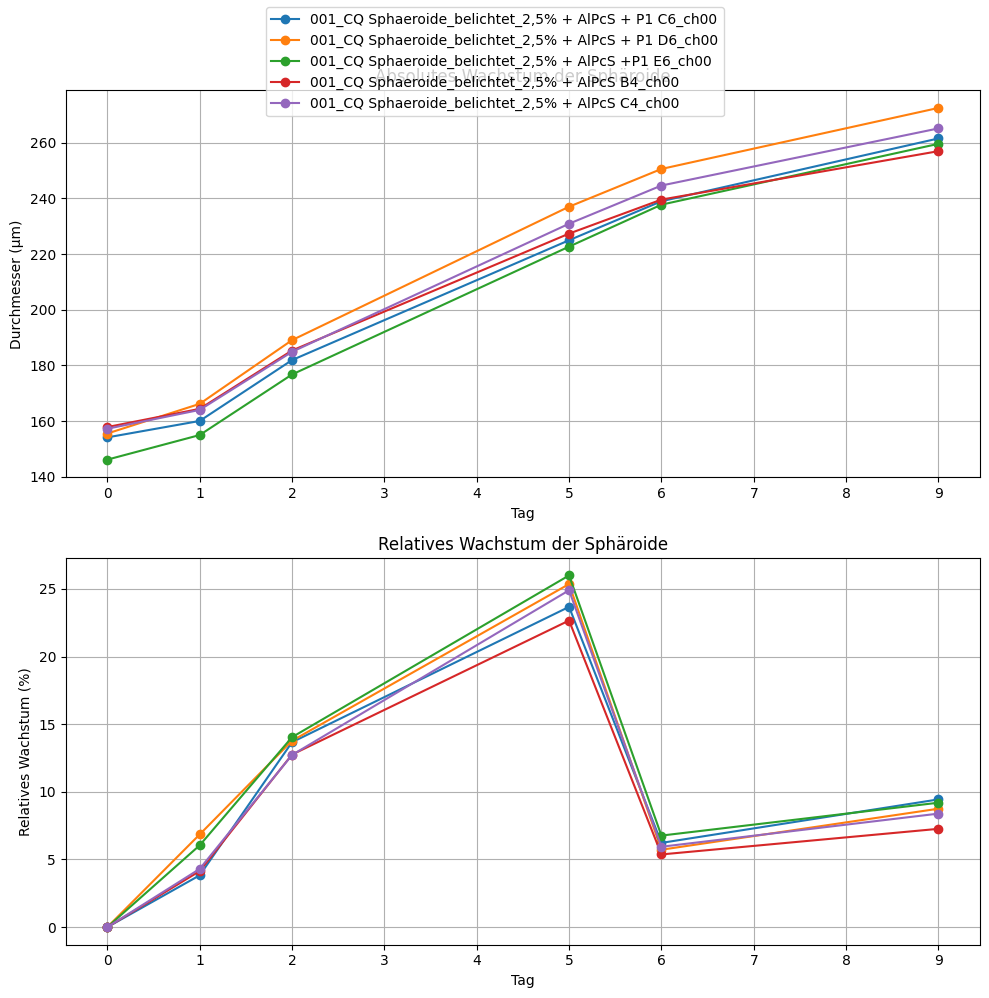

Excel-Datei mit Durchmessern unter C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/vorhergesagte_durchmesser.xlsx gespeichert.


In [36]:
import re
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from tensorflow.keras.models import load_model
import pandas as pd

# Funktion zur Extraktion des Tags aus Dateinamen, z.B. "tag1", "tag 1", "tag2", "tag 2"
def extract_tag_from_filename(filename):
    match = re.search(r'tag[\s]?(\d+)', filename, re.IGNORECASE)
    return int(match.group(1)) if match else None  # Rückgabe als Integer

# Funktion zur Extraktion des Basenamens ohne Tag, z.B. "Bild1" ohne "tag1" oder "tag 1"
def extract_base_filename(filename):
    return re.sub(r'_tag[\s]?\d+', '', filename, flags=re.IGNORECASE)

# Bildvorverarbeitung
def load_and_preprocess_image_pillow(img_path):
    img = Image.open(img_path).convert('L')  # Konvertierung in Graustufen
    img = img.resize((256, 192))  # Größe anpassen
    img = np.array(img)  # PIL Image zu numpy Array konvertieren
    img = img / 255.0  # Normalisierung auf den Bereich [0, 1]
    img = np.expand_dims(img, axis=-1)  # Einen Kanal hinzufügen
    return img

# Vorhersage mit dem Modell
def predict_with_model(model, image):
    image = np.expand_dims(image, axis=0)  # Batch-Dimension hinzufügen
    predicted_mask = model.predict(image)  # Vorhersage machen
    return np.squeeze(predicted_mask)  # Batch-Dimension entfernen

# Funktion zum Zeichnen von Konturen und Schwerpunkten
def draw_contours_and_centroid(binary_mask, output_path):
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    color_mask = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(color_mask, contours, -1, (0, 255, 0), 2)
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(color_mask, (cX, cY), 5, (0, 0, 255), -1)
    cv2.imwrite(output_path, color_mask)

# Funktion zur Berechnung des mittleren Durchmessers
def calculate_average_diameter(contour, center, num_lines=180):
    angles = np.linspace(0, 2 * np.pi, num=num_lines, endpoint=False)
    diameters = []
    for angle in angles:
        dx = np.cos(angle)
        dy = np.sin(angle)
        intersections = []
        for i in range(-1000, 1000):
            x = int(center[0] + i * dx)
            y = int(center[1] + i * dy)
            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:
                intersections.append((x, y))
        if len(intersections) >= 2:
            d = np.linalg.norm(np.array(intersections[0]) - np.array(intersections[-1]))
            diameters.append(d)
    return np.mean(diameters)

# Gruppierung der Ergebnisse nach Name
def organize_results_by_basename_and_tag(tif_files, predicted_diameters):
    grouped_results = {}
    for i, filename in enumerate(tif_files):
        base_name = extract_base_filename(filename)
        tag = extract_tag_from_filename(filename)  # Tag als Integer extrahieren
        if base_name not in grouped_results:
            grouped_results[base_name] = {}
        if tag is not None:
            grouped_results[base_name][tag] = predicted_diameters[i]  # Tag als Schlüssel hinzufügen
    return grouped_results

# Funktion zum Plotten der absoluten und relativen Wachstumskurven als Subplots
def plot_growth_curves_with_relative(grouped_results, output_path):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))  # Zwei Subplots
    
    for base_name, measurements in grouped_results.items():
        days = sorted(measurements.keys())  # Tage sortieren
        diameters = [measurements[day] for day in days]

        # Entfernen der .tif-Endung für die Legende
        base_name_cleaned = base_name.replace('.tif', '')

        # Absolutes Wachstum (Durchmesser)
        ax1.plot(days, diameters, marker='o', linestyle='-', label=base_name_cleaned)

        # Relatives Wachstum (in Prozent)
        relative_growth = [((diameters[i] - diameters[i - 1]) / diameters[i - 1]) * 100 if i > 0 else 0 for i in range(len(diameters))]
        ax2.plot(days, relative_growth, marker='o', linestyle='-', label=base_name_cleaned)

    # Plot für absolutes Wachstum
    ax1.set_xlabel('Tag')
    ax1.set_ylabel('Durchmesser (µm)')
    ax1.set_title('Absolutes Wachstum der Sphäroide')
    ax1.grid(True)

    # Setzen der X-Ticks auf ganze Tage
    ax1.set_xticks(range(int(min(days)), int(max(days)) + 1))

    # Plot für relatives Wachstum
    ax2.set_xlabel('Tag')
    ax2.set_ylabel('Relatives Wachstum (%)')
    ax2.set_title('Relatives Wachstum der Sphäroide')
    ax2.grid(True)

    # Setzen der X-Ticks auf ganze Tage für relatives Wachstum
    ax2.set_xticks(range(int(min(days)), int(max(days)) + 1))

    # Gemeinsame Legende für beide Subplots
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center')

    # Diagramm speichern
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Platz für Legende lassen
    plt.savefig(output_path)
    plt.show()

# Pfade definieren
input_dir = "C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Bilder für Wachstumskurve"
output_dir = "C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout_3 beste bisher test"
excel_output_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/vorhergesagte_durchmesser.xlsx'  # Pfad für die Excel-Datei

# Lade das Modell
model = load_model('C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_unet_trained3.h5', compile=False)

# Skalierungsfaktoren berechnen
scale_factor_width = 1296 / 256  # Originalbreite / skalierte Breite
scale_factor_height = 966 / 196  # Originalhöhe / skalierte Höhe

# TIFF-Dateien finden
tif_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]
predicted_diameters = []

# Liste für Excel-Tabelle
excel_data = []

# Iteration über alle TIFF-Dateien
for filename in tif_files:
    img_path = os.path.join(input_dir, filename)
    image = load_and_preprocess_image_pillow(img_path)
    predicted_mask = predict_with_model(model, image)

    # Binarisierung der Vorhersage
    binary_mask = (predicted_mask > 0.5).astype(np.uint8) * 255

    # Konturen finden
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        print(f"Keine Konturen im Bild {filename} gefunden.")
        continue

    # Größte Kontur finden
    largest_contour = max(contours, key=cv2.contourArea)

    # Schwerpunkt berechnen
    M = cv2.moments(largest_contour)
    if M["m00"] == 0:
        print(f"Schwerpunkt konnte im Bild {filename} nicht berechnet werden.")
        continue
    center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

    # Mittleren Durchmesser berechnen
    avg_diameter_pixels = calculate_average_diameter(largest_contour, center)
    avg_diameter_micrometers = avg_diameter_pixels * (0.3745 * scale_factor_width) * 0.994  # Mit Verzerrungsfaktor

    # Ergebnisse speichern
    predicted_diameters.append(avg_diameter_micrometers)
    excel_data.append([filename, avg_diameter_micrometers])  # Daten für Excel-Tabelle hinzufügen

    # Ausgabepfad für das segmentierte Bild definieren
    output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_segmentiert.tif")
    draw_contours_and_centroid(binary_mask, output_path)

    # Ausgabe des Durchmessers in der Konsole
    print(f"Bild: {filename}, Durchmesser: {avg_diameter_micrometers:.2f} µm gespeichert.")

# Organisieren der Ergebnisse nach Basename und Tag
grouped_results = organize_results_by_basename_and_tag(tif_files, predicted_diameters)

# Wachstumskurven (absolut und relativ) erstellen und speichern
output_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/wachstumskurve_subplots.png'
plot_growth_curves_with_relative(grouped_results, output_path)

# Erstellen der Excel-Datei
df = pd.DataFrame(excel_data, columns=['Bildname', 'Vorhergesagter Durchmesser (µm)'])
df.to_excel(excel_output_path, index=False)

print(f"Excel-Datei mit Durchmessern unter {excel_output_path} gespeichert.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Bild: 001_CQ Sphaeroide_Tag0_belichtet_2,5% + AlPcS + P1 C6_ch00.tif, Durchmesser: 11.40 µm, Fläche: 103.93 µm² gespeichert.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
Bild: 001_CQ Sphaeroide_Tag0_belichtet_2,5% + AlPcS + P1 D6_ch00.tif, Durchmesser: 11.51 µm, Fläche: 105.80 µm² gespeichert.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
Bild: 001_CQ Sphaeroide_Tag0_belichtet_2,5% + AlPcS +P1 E6_ch00.tif, Durchmesser: 10.81 µm, Fläche: 93.46 µm² gespeichert.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
Bild: 001_CQ Sphaeroide_Tag0_belichtet_2,5% + AlPcS B4_ch00.tif, Durchmesser: 11.68 µm, Fläche: 108.92 µm² gespeichert.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
Bild: 001_CQ Sphaeroide_Tag0_belichtet_2,5% + AlPcS C4_ch00.tif, Durchmesser: 11.63 µm, Fläche: 108.24 µm² gespeichert.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 609ms/step
Bild: 001_CQ Sphaeroide_Tag1_belichtet_2,5% + AlPcS + P1 C6_ch00.tif, Durchmesser: 11.84 µm, Fläche: 111.96 µm² gespeichert.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615

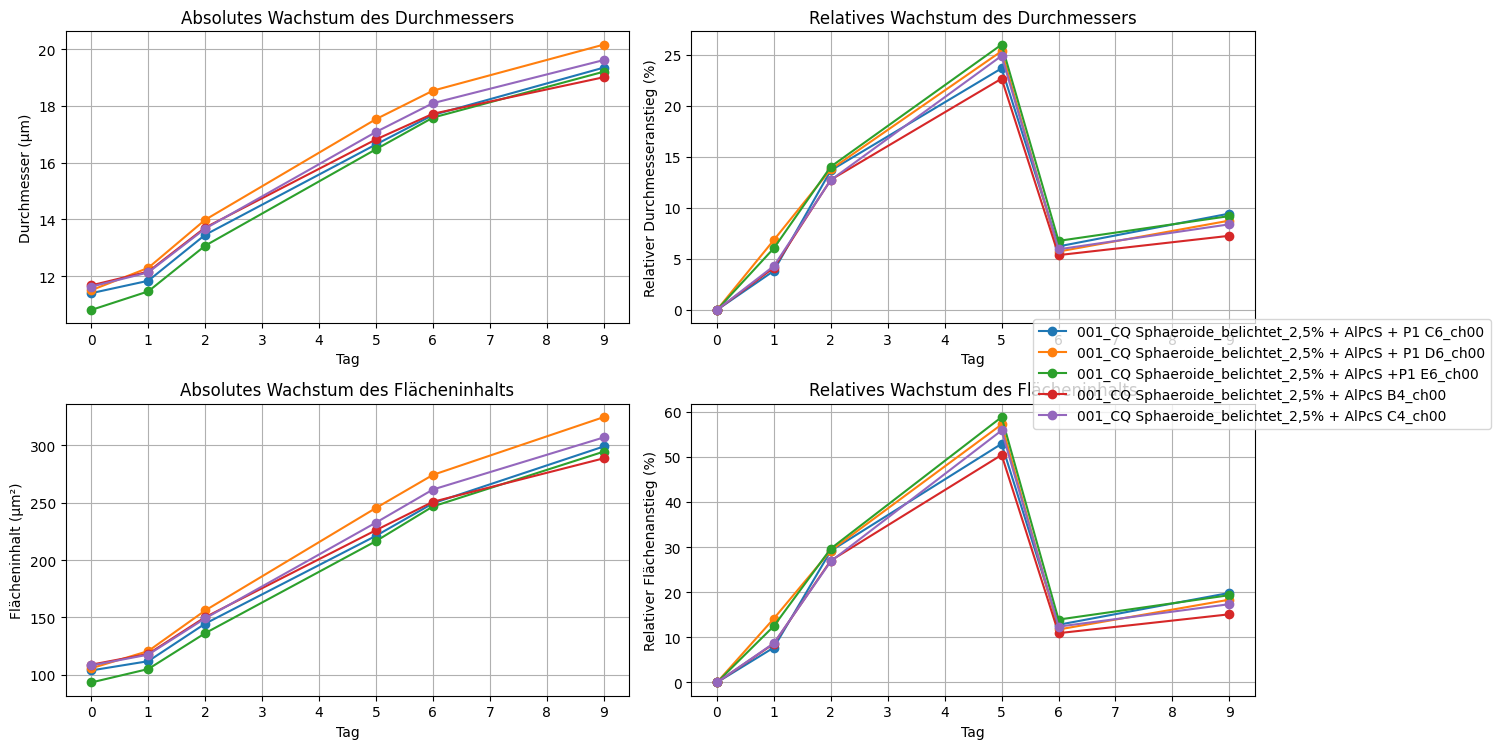

Excel-Datei mit Durchmessern und Flächeninhalt unter C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/vorhergesagte_durchmesser_und_flaecheninhalt.xlsx gespeichert.


In [4]:
import re
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from tensorflow.keras.models import load_model
import pandas as pd

# Funktion zur Extraktion des Tags aus Dateinamen, z.B. "tag1", "tag 1", "tag2", "tag 2"
def extract_tag_from_filename(filename):
    match = re.search(r'tag[\s]?(\d+)', filename, re.IGNORECASE)
    return int(match.group(1)) if match else None  # Rückgabe als Integer

# Funktion zur Extraktion des Basenamens ohne Tag, z.B. "Bild1" ohne "tag1" oder "tag 1"
def extract_base_filename(filename):
    return re.sub(r'_tag[\s]?\d+', '', filename, flags=re.IGNORECASE)

# Bildvorverarbeitung
def load_and_preprocess_image_pillow(img_path):
    img = Image.open(img_path).convert('L')  # Konvertierung in Graustufen
    img = img.resize((256, 192))  # Größe anpassen
    img = np.array(img)  # PIL Image zu numpy Array konvertieren
    img = img / 255.0  # Normalisierung auf den Bereich [0, 1]
    img = np.expand_dims(img, axis=-1)  # Einen Kanal hinzufügen
    return img

# Vorhersage mit dem Modell
def predict_with_model(model, image):
    image = np.expand_dims(image, axis=0)  # Batch-Dimension hinzufügen
    predicted_mask = model.predict(image)  # Vorhersage machen
    return np.squeeze(predicted_mask)  # Batch-Dimension entfernen

# Funktion zum Zeichnen von Konturen und Schwerpunkten
def draw_contours_and_centroid(binary_mask, output_path):
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    color_mask = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(color_mask, contours, -1, (0, 255, 0), 2)
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(color_mask, (cX, cY), 5, (0, 0, 255), -1)
    cv2.imwrite(output_path, color_mask)

# Funktion zur Berechnung des mittleren Durchmessers
def calculate_average_diameter(contour, center, num_lines=180):
    angles = np.linspace(0, 2 * np.pi, num=num_lines, endpoint=False)
    diameters = []
    for angle in angles:
        dx = np.cos(angle)
        dy = np.sin(angle)
        intersections = []
        for i in range(-1000, 1000):
            x = int(center[0] + i * dx)
            y = int(center[1] + i * dy)
            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:
                intersections.append((x, y))
        if len(intersections) >= 2:
            d = np.linalg.norm(np.array(intersections[0]) - np.array(intersections[-1]))
            diameters.append(d)
    return np.mean(diameters)

# Gruppierung der Ergebnisse nach Name und Tag (Durchmesser und Flächeninhalt)
def organize_results_by_basename_and_tag(tif_files, measurements):
    grouped_results = {}
    for i, filename in enumerate(tif_files):
        base_name = extract_base_filename(filename)
        tag = extract_tag_from_filename(filename)  # Tag als Integer extrahieren
        if base_name not in grouped_results:
            grouped_results[base_name] = {}
        if tag is not None:
            grouped_results[base_name][tag] = measurements[i]  # Messungen (Durchmesser und Fläche) hinzufügen
    return grouped_results

# Funktion zum Plotten der Wachstumskurven für Durchmesser und Flächeninhalt
def plot_diameter_and_area_growth(grouped_results, output_path):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))  # Breitere x-Achse

    for base_name, measurements in grouped_results.items():
        days = sorted(measurements.keys())  # Tage sortieren
        
        # Absoluter Durchmesser und Flächeninhalt
        diameters = [measurements[day]['diameter'] for day in days]
        areas = [measurements[day]['area'] for day in days]

        # Entfernen der .tif-Endung für die Legende
        base_name_cleaned = base_name.replace('.tif', '')

        # Plot für absolutes Wachstum (Durchmesser)
        ax1.plot(days, diameters, marker='o', linestyle='-', label=base_name_cleaned)
        
        # Relatives Wachstum (Durchmesser)
        relative_diameter_growth = [((diameters[i] - diameters[i - 1]) / diameters[i - 1]) * 100 if i > 0 else 0 for i in range(len(diameters))]
        ax2.plot(days, relative_diameter_growth, marker='o', linestyle='-', label=base_name_cleaned)

        # Plot für absolutes Wachstum (Flächeninhalt)
        ax3.plot(days, areas, marker='o', linestyle='-', label=base_name_cleaned)

        # Relatives Wachstum (Flächeninhalt)
        relative_area_growth = [((areas[i] - areas[i - 1]) / areas[i - 1]) * 100 if i > 0 else 0 for i in range(len(areas))]
        ax4.plot(days, relative_area_growth, marker='o', linestyle='-', label=base_name_cleaned)

    # Plot für absolutes Wachstum (Durchmesser)
    ax1.set_xticks(np.arange(min(days), max(days) + 1, 1))  # Durchgehende ganze Zahlen auf der x-Achse
    ax1.set_xlabel('Tag')
    ax1.set_ylabel('Durchmesser (µm)')
    ax1.set_title('Absolutes Wachstum des Durchmessers')
    ax1.grid(True)
    
    # Plot für relatives Wachstum (Durchmesser)
    ax2.set_xticks(np.arange(min(days), max(days) + 1, 1))  # Durchgehende ganze Zahlen auf der x-Achse
    ax2.set_xlabel('Tag')
    ax2.set_ylabel('Relativer Durchmesseranstieg (%)')
    ax2.set_title('Relatives Wachstum des Durchmessers')
    ax2.grid(True)

    # Plot für absolutes Wachstum (Flächeninhalt)
    ax3.set_xticks(np.arange(min(days), max(days) + 1, 1))  # Durchgehende ganze Zahlen auf der x-Achse
    ax3.set_xlabel('Tag')
    ax3.set_ylabel('Flächeninhalt (µm²)')
    ax3.set_title('Absolutes Wachstum des Flächeninhalts')
    ax3.grid(True)

    # Plot für relatives Wachstum (Flächeninhalt)
    ax4.set_xticks(np.arange(min(days), max(days) + 1, 1))  # Durchgehende ganze Zahlen auf der x-Achse
    ax4.set_xlabel('Tag')
    ax4.set_ylabel('Relativer Flächenanstieg (%)')
    ax4.set_title('Relatives Wachstum des Flächeninhalts')
    ax4.grid(True)

    # Gemeinsame Legende für alle Subplots rechts vom letzten Plot
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right')

    # Diagramm speichern
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])  # Platz für Legende lassen
    plt.savefig(output_path)
    plt.show()

# Pfade definieren
input_dir = "C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Bilder für Wachstumskurve"
output_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout 3 beste bisher test/'
excel_output_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/vorhergesagte_durchmesser_und_flaecheninhalt.xlsx'  # Pfad für die Excel-Datei
output_plot_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/wachstumskurve_durchmesser_und_flaecheninhalt.png'

# Lade das Modell
model = load_model('C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_unet_trained3.h5', compile=False)

# Skalierungsfaktoren berechnen
scale_factor_width = 0.3745  # Beispielwert für Breite
scale_factor_height = 0.3745  # Beispielwert für Höhe

# Verarbeite alle TIFF-Bilder im Eingabeverzeichnis
tif_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]
predicted_diameters = []
predicted_areas = []
excel_data = []

for filename in tif_files:
    # Bild laden und vorverarbeiten
    img_path = os.path.join(input_dir, filename)
    image = load_and_preprocess_image_pillow(img_path)

    # Vorhersage mit dem Modell
    predicted_mask = predict_with_model(model, image)

    # Binäre Maske erstellen
    binary_mask = (predicted_mask > 0.5).astype(np.uint8) * 255

    # Konturen finden
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        print(f"Keine Konturen im Bild {filename} gefunden.")
        continue

    # Größte Kontur finden
    largest_contour = max(contours, key=cv2.contourArea)

    # Schwerpunkt berechnen
    M = cv2.moments(largest_contour)
    if M["m00"] == 0:
        print(f"Schwerpunkt konnte im Bild {filename} nicht berechnet werden.")
        continue
    center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

    # Mittleren Durchmesser berechnen
    avg_diameter_pixels = calculate_average_diameter(largest_contour, center)
    avg_diameter_micrometers = avg_diameter_pixels * (0.3745 * scale_factor_width) * 0.994  # Mit Verzerrungsfaktor

    # Flächeninhalt berechnen
    area_pixels = cv2.contourArea(largest_contour)
    area_micrometers = area_pixels * (0.3745 * scale_factor_width) * (0.3745 * scale_factor_height)

    # Ergebnisse speichern
    predicted_diameters.append(avg_diameter_micrometers)
    predicted_areas.append(area_micrometers)
    excel_data.append([filename, avg_diameter_micrometers, area_micrometers])  # Daten für Excel-Tabelle hinzufügen

    # Ausgabepfad für das segmentierte Bild definieren
    output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_segmentiert.tif")
    draw_contours_and_centroid(binary_mask, output_path)

    # Ausgabe des Durchmessers und Flächeninhalts in der Konsole
    print(f"Bild: {filename}, Durchmesser: {avg_diameter_micrometers:.2f} µm, Fläche: {area_micrometers:.2f} µm² gespeichert.")

# Organisieren der Ergebnisse nach Basename und Tag
grouped_results = organize_results_by_basename_and_tag(tif_files, [{'diameter': d, 'area': a} for d, a in zip(predicted_diameters, predicted_areas)])

# Wachstumskurven für Durchmesser und Flächeninhalt erstellen und speichern
plot_diameter_and_area_growth(grouped_results, output_plot_path)

# Erstellen der Excel-Datei
df = pd.DataFrame(excel_data, columns=['Bildname', 'Vorhergesagter Durchmesser (µm)', 'Flächeninhalt (µm²)'])
df.to_excel(excel_output_path, index=False)

print(f"Excel-Datei mit Durchmessern und Flächeninhalt unter {excel_output_path} gespeichert.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Bild: 001_CQ Sphaeroide_Tag0_belichtet_2,5% + AlPcS + P1 C6_ch00.tif, Durchmesser: 154.13 µm, Flächeninhalt: 18488.92 µm² gespeichert.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
Bild: 001_CQ Sphaeroide_Tag0_belichtet_2,5% + AlPcS + P1 D6_ch00.tif, Durchmesser: 155.53 µm, Flächeninhalt: 18821.36 µm² gespeichert.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
Bild: 001_CQ Sphaeroide_Tag0_belichtet_2,5% + AlPcS +P1 E6_ch00.tif, Durchmesser: 146.14 µm, Flächeninhalt: 16627.25 µm² gespeichert.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
Bild: 001_CQ Sphaeroide_Tag0_belichtet_2,5% + AlPcS B4_ch00.tif, Durchmesser: 157.85 µm, Flächeninhalt: 19377.76 µm² gespeichert.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
Bild: 001_CQ Sphaeroide_Tag0_belichtet_2,5% + AlPcS C4_ch00.tif, Durchmesser: 157.24 µm, Flächeninhalt: 19257.03 µm² gespeichert.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
Bild: 001_CQ Sphaeroide_Tag1_belichtet_2,5% + AlPcS + P1 C6_ch00.tif, Durchmesser: 160.04 µm, Flächeninha

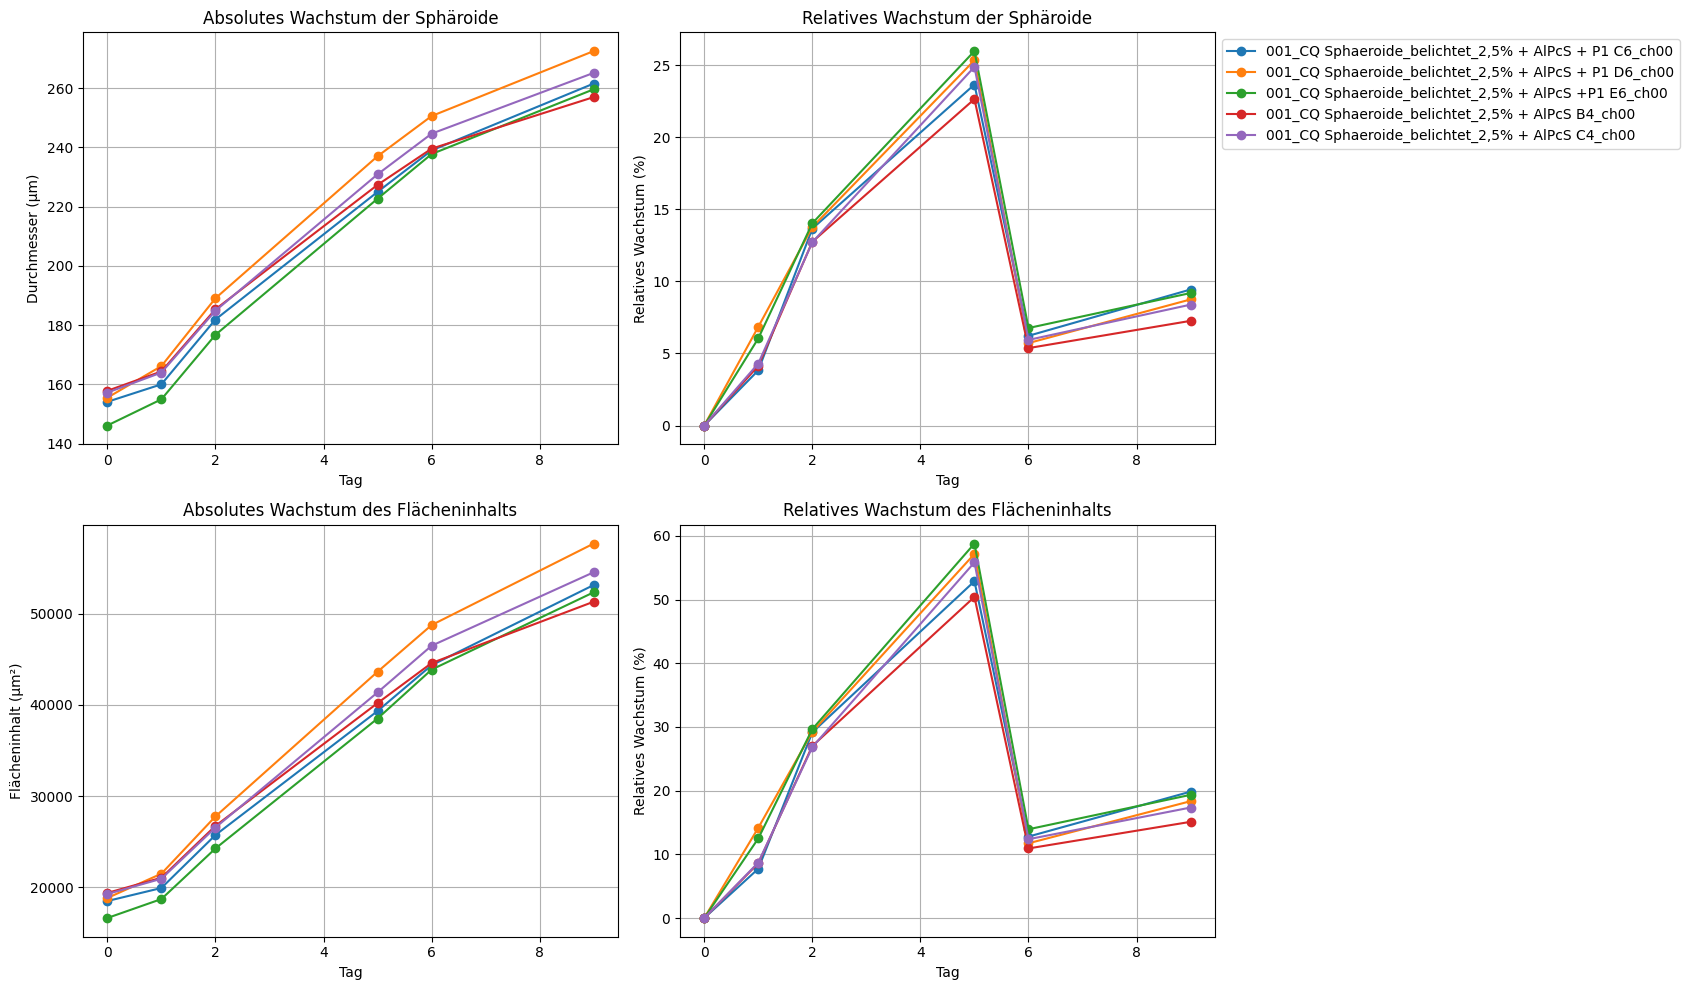

Excel-Datei mit Durchmessern und Flächeninhalten unter C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/vorhergesagte_durchmesser.xlsx gespeichert.


In [45]:
import re
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from tensorflow.keras.models import load_model
import pandas as pd

# Funktion zur Extraktion des Tags aus Dateinamen
def extract_tag_from_filename(filename):
    match = re.search(r'tag[\s]?(\d+)', filename, re.IGNORECASE)
    return int(match.group(1)) if match else None

# Funktion zur Extraktion des Basenamens ohne Tag
def extract_base_filename(filename):
    return re.sub(r'_tag[\s]?\d+', '', filename, flags=re.IGNORECASE)

# Bildvorverarbeitung
def load_and_preprocess_image_pillow(img_path):
    img = Image.open(img_path).convert('L')
    img = img.resize((256, 192))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=-1)
    return img

# Vorhersage mit dem Modell
def predict_with_model(model, image):
    image = np.expand_dims(image, axis=0)
    predicted_mask = model.predict(image)
    return np.squeeze(predicted_mask)

# Funktion zum Zeichnen von Konturen und Schwerpunkten
def draw_contours_and_centroid(binary_mask, output_path):
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    color_mask = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(color_mask, contours, -1, (0, 255, 0), 2)
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(color_mask, (cX, cY), 5, (0, 0, 255), -1)
    cv2.imwrite(output_path, color_mask)

# Funktion zur Berechnung des mittleren Durchmessers
def calculate_average_diameter(contour, center, num_lines=180):
    angles = np.linspace(0, 2 * np.pi, num=num_lines, endpoint=False)
    diameters = []
    for angle in angles:
        dx = np.cos(angle)
        dy = np.sin(angle)
        intersections = []
        for i in range(-1000, 1000):
            x = int(center[0] + i * dx)
            y = int(center[1] + i * dy)
            if cv2.pointPolygonTest(contour, (x, y), False) >= 0:
                intersections.append((x, y))
        if len(intersections) >= 2:
            d = np.linalg.norm(np.array(intersections[0]) - np.array(intersections[-1]))
            diameters.append(d)
    return np.mean(diameters)

# Gruppierung der Ergebnisse nach Name
def organize_results_by_basename_and_tag(tif_files, predicted_diameters, predicted_areas):
    grouped_results = {}
    for i, filename in enumerate(tif_files):
        base_name = extract_base_filename(filename)
        tag = extract_tag_from_filename(filename)
        if base_name not in grouped_results:
            grouped_results[base_name] = {}
        if tag is not None:
            grouped_results[base_name][tag] = {
                'diameter': predicted_diameters[i],
                'area': predicted_areas[i]  # Flächeninhalt hinzufügen
            }
    return grouped_results

# Funktion zum Plotten der Wachstumskurven
# Funktion zum Plotten der Wachstumskurven
def plot_growth_curves_with_relative(grouped_results, output_path):
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))  # 2x2 Subplots
    
    for base_name, measurements in grouped_results.items():
        days = sorted(measurements.keys())
        diameters = [measurements[day]['diameter'] for day in days]
        areas = [measurements[day]['area'] for day in days]

        # Entfernen der .tif-Endung für die Legende
        base_name_cleaned = base_name.replace('.tif', '')

        # Absolutes Wachstum (Durchmesser)
        axs[0, 0].plot(days, diameters, marker='o', linestyle='-', label=base_name_cleaned)

        # Relatives Wachstum (Durchmesser in Prozent)
        relative_growth_diameter = [((diameters[i] - diameters[i - 1]) / diameters[i - 1]) * 100 if i > 0 else 0 for i in range(len(diameters))]
        axs[0, 1].plot(days, relative_growth_diameter, marker='o', linestyle='-', label=base_name_cleaned)

        # Absolutes Wachstum (Flächeninhalt)
        axs[1, 0].plot(days, areas, marker='o', linestyle='-', label=base_name_cleaned)

        # Relatives Wachstum (Flächeninhalt in Prozent)
        relative_growth_area = [((areas[i] - areas[i - 1]) / areas[i - 1]) * 100 if i > 0 else 0 for i in range(len(areas))]
        axs[1, 1].plot(days, relative_growth_area, marker='o', linestyle='-', label=base_name_cleaned)

    # Plot für absolutes Wachstum (Durchmesser)
    axs[0, 0].set_xlabel('Tag')
    axs[0, 0].set_ylabel('Durchmesser (µm)')
    axs[0, 0].set_title('Absolutes Wachstum der Sphäroide')
    axs[0, 0].grid(True)

    # Plot für relatives Wachstum (Durchmesser)
    axs[0, 1].set_xlabel('Tag')
    axs[0, 1].set_ylabel('Relatives Wachstum (%)')
    axs[0, 1].set_title('Relatives Wachstum der Sphäroide')
    axs[0, 1].grid(True)
    axs[0, 1].legend(loc='upper left', bbox_to_anchor=(1, 1))  # Legende rechts oben

    # Plot für absolutes Wachstum (Flächeninhalt)
    axs[1, 0].set_xlabel('Tag')
    axs[1, 0].set_ylabel('Flächeninhalt (µm²)')
    axs[1, 0].set_title('Absolutes Wachstum des Flächeninhalts')
    axs[1, 0].grid(True)

    # Plot für relatives Wachstum (Flächeninhalt)
    axs[1, 1].set_xlabel('Tag')
    axs[1, 1].set_ylabel('Relatives Wachstum (%)')
    axs[1, 1].set_title('Relatives Wachstum des Flächeninhalts')
    axs[1, 1].grid(True)

    # Diagramm speichern
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Platz für Legende lassen
    plt.savefig(output_path)
    plt.show()


# Pfade definieren
input_dir = "C:/Users/chris/Documents/Master/Sphaeroidauswertung/Trainingsset/Bilder für Wachstumskurve"
output_dir = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/Segmentierte_Bilder_mit_dropout 3 beste bisher test/'
excel_output_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/vorhergesagte_durchmesser.xlsx'

# Lade das Modell
model = load_model('C:/Users/chris/Documents/Master/Sphaeroidauswertung/Modelle/spheroid_segmentation_unet_trained3.h5', compile=False)

# Skalierungsfaktoren berechnen
scale_factor_width = 1296 / 256
scale_factor_height = 966 / 196

# TIFF-Dateien finden
tif_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]
predicted_diameters = []
predicted_areas = []  # Liste für Flächeninhalte

# Liste für Excel-Tabelle
excel_data = []

# Iteration über alle TIFF-Dateien
for filename in tif_files:
    img_path = os.path.join(input_dir, filename)
    image = load_and_preprocess_image_pillow(img_path)
    predicted_mask = predict_with_model(model, image)

    # Binarisierung der Vorhersage
    binary_mask = (predicted_mask > 0.5).astype(np.uint8) * 255

    # Konturen finden
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        print(f"Keine Konturen im Bild {filename} gefunden.")
        continue

    # Größte Kontur finden
    largest_contour = max(contours, key=cv2.contourArea)

    # Schwerpunkt berechnen
    M = cv2.moments(largest_contour)
    if M["m00"] == 0:
        print(f"Schwerpunkt konnte im Bild {filename} nicht berechnet werden.")
        continue
    center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

    # Mittleren Durchmesser berechnen
    avg_diameter_pixels = calculate_average_diameter(largest_contour, center)
    avg_diameter_micrometers = avg_diameter_pixels * (0.3745 * scale_factor_width) * 0.994

    # Flächeninhalt berechnen
    area_pixels = cv2.contourArea(largest_contour)
    area_micrometers = area_pixels * (0.3745 * scale_factor_width) * (0.3745 * scale_factor_height)  # Umrechnen in µm²

    # Ergebnisse speichern
    predicted_diameters.append(avg_diameter_micrometers)
    predicted_areas.append(area_micrometers)  # Flächeninhalt speichern
    excel_data.append([filename, avg_diameter_micrometers, area_micrometers])  # Daten für Excel-Tabelle hinzufügen

    # Ausgabepfad für das segmentierte Bild definieren
    output_path = os.path.join(output_dir, f"{os.path.splitext(filename)[0]}_segmentiert.tif")
    draw_contours_and_centroid(binary_mask, output_path)

    # Ausgabe des Durchmessers und Flächeninhalts in der Konsole
    print(f"Bild: {filename}, Durchmesser: {avg_diameter_micrometers:.2f} µm, Flächeninhalt: {area_micrometers:.2f} µm² gespeichert.")

# Organisieren der Ergebnisse nach Basename und Tag
grouped_results = organize_results_by_basename_and_tag(tif_files, predicted_diameters, predicted_areas)

# Wachstumskurven (absolut und relativ) erstellen und speichern
output_path = 'C:/Users/chris/Documents/Master/Sphaeroidauswertung/Ergebnisse/wachstumskurve_subplots.png'
plot_growth_curves_with_relative(grouped_results, output_path)

# Erstellen der Excel-Datei
df = pd.DataFrame(excel_data, columns=['Bildname', 'Vorhergesagter Durchmesser (µm)', 'Flächeninhalt (µm²)'])
df.to_excel(excel_output_path, index=False)

print(f"Excel-Datei mit Durchmessern und Flächeninhalten unter {excel_output_path} gespeichert.")
